<center> <h2><b>SkillCorner Data - Jupyter Notebook</b></h2> </center>

<h3><b>Introduction</b></h3>

We will walk through the [SkillCorner](https://skillcorner.com)'s tracking and [game intelligence](https://skillcorner.com/contextual-data) data focusing on preprocessing steps of only one sample match.

You can run each cell in this notebook to see the output. 

You should have moved the tracking zip file into the `skillcorner` subfolder inside the `input` folder in the current directory.

This notebook has been tested with Python 3.11 and we don't think there is any issue using it with any version of python 3. We do recommend using a virtual environment for your project such as [pipenv](https://pipenv.pypa.io/en/latest), as covered in the first practical session.

Let's first import the rquired packages:

In [1]:
from datetime import datetime, timedelta
from mplsoccer import VerticalPitch
from matplotlib import animation
import matplotlib.pyplot as plt
from pathlib import Path
import imageio.v2 as iio
from tqdm import tqdm
import pandas as pd
import matplotlib
import zipfile
import shutil
import time
import json
import enum

# set pandas option to show columns of a dataframe
pd.set_option('display.max_columns', None)

Below, we specify the path to each individual given skillcorner file.

In [2]:
# Define the directories
input_dir = Path("input/skillcorner")

# data_dir is where the processed raw data will be stored in
data_dir = Path("data")

# Create the data_dir if it does not exist
if not data_dir.exists():
    data_dir.mkdir()

# You can adjust the match_id according to your assigned task
match_id = "1381516"

# skillcorner zip file path
zip_file = input_dir / f"{match_id}.zip"

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(input_dir)

# match metadata and tracking data file paths
metadata_file = input_dir / f"{match_id}.jsonl"
tracking_file = input_dir / f"{match_id}_tracking_extrapolated.jsonl"

# game intelligence data file paths
physical_file = input_dir / f"{match_id}_physical.json"
passes_file = input_dir / f"{match_id}_passes.json"
on_ball_pressures_file = input_dir / f"{match_id}_on_ball_pressures.json"
off_ball_runs_file = input_dir / f"{match_id}_off_ball_runs.json"

Next, we have one cell containing all the data extraction functions and variables we use:

In [4]:
class Direction(enum.Enum):
    """Enum for the directions of a match."""
    BOTTOM_TO_TOP = "BOTTOM_TO_TOP"
    TOP_TO_BOTTOM = "TOP_TO_BOTTOM"


class PhaseNames(enum.Enum):
    """Enum for the phases of a match."""
    IN_POSSESSION = "IN_POSSESSION"
    OUT_POSSESSION = "OUT_POSSESSION"
    IN_CONTEST = "IN_CONTEST"
    NONE = "NONE"

side_dict = {
    "b2t": [Direction.BOTTOM_TO_TOP, Direction.TOP_TO_BOTTOM], #bottom2top
    "t2b": [Direction.TOP_TO_BOTTOM, Direction.BOTTOM_TO_TOP], #top2bottom
}

def execution_time(start_time):
    """Print the execution time from the start_time to the current time."""
    seconds = timedelta(seconds=time.time() - start_time).total_seconds()
    minutes = seconds // 60
    seconds %= 60
    print("Execution Time is %02d:%02d" % (minutes, seconds))

def list_to_csv(list, path):
    """This function stores a list of dictionaries into a CSV file"""
    pd.DataFrame(list).to_csv(path, index=False)

Below, we provide class to parse SkillCorner data.

In [9]:
class SkillCorner:
    fps = 10 # The frame rate of the SkillCorner data
    ball_id = "-1" # ball_id stored in the output CSV files
        
    def load(self, match_id, metadata_file, tracking_file, physical_file, passes_file, on_ball_pressures_file, off_ball_runs_file):
        """This function loads the skillcorner data from the given file and saves it in the database."""
        
        start_time = time.time()
        with open(metadata_file, encoding="utf-8") as f:
            metadata = json.load(f)

        # basic match info
        match = {}
        match["match_id"] = match_id
        match["match_date"] = datetime.strptime(metadata["date_time"], "%Y-%m-%dT%H:%M:%SZ").strftime("%m/%d/%Y %H:%M")
        match["competition"] = metadata["competition_edition"]["competition"]["name"]
        match["season"] = metadata["competition_edition"]["season"]["name"]
        match["home_team"] = metadata["home_team"]["name"]
        match["away_team"] = metadata["away_team"]["name"]
        match["home_score"] = int(metadata["home_team_score"])
        match["away_score"] = int(metadata["away_team_score"])
        match["home_team_jersey_color"] = metadata["home_team_kit"]["jersey_color"]
        match["away_team_jersey_color"] = metadata["away_team_kit"]["jersey_color"]
        match["home_team_number_color"] = metadata["home_team_kit"]["number_color"]
        match["away_team_number_color"] = metadata["away_team_kit"]["number_color"]
        match["home_team_coach"] = f'{metadata["home_team_coach"]["first_name"]} {metadata["home_team_coach"]["last_name"]}'
        match["away_team_coach"] = f'{metadata["away_team_coach"]["first_name"]} {metadata["away_team_coach"]["last_name"]}'
        match["pitch_name"]= metadata["stadium"]["name"]
        match["pitch_length"]=float(metadata["pitch_length"])
        match["pitch_width"]=float(metadata["pitch_width"])
        match["provider"] = "SkillCorner"
        match["fps"] = self.fps
        list_to_csv([match], data_dir / f"{match_id}_metadata.csv")

        print(f"Metadata {match_id} added ...")

        # play direction part
        if metadata["home_team_side"][0] == "left_to_right":
            starting_left_to_right_team = metadata["home_team"]["name"]
            starting_right_to_left_team = metadata["away_team"]["name"]
        else:
            starting_left_to_right_team = metadata["away_team"]["name"]
            starting_right_to_left_team = metadata["home_team"]["name"]

        halves = [half_number for half_number in range(1,len(metadata["home_team_side"])+1)]
        play_directions = []
        for half in halves:
            play_direction = {}
            play_direction["match_id"] = match_id
            play_direction["team_name"] = starting_left_to_right_team
            play_direction["half"] = half
            play_direction["play_direction"] = side_dict["b2t"][(half - 1) % 2].value
            play_directions.append(play_direction)

            play_direction = {}
            play_direction["match_id"] = match_id
            play_direction["team_name"] = starting_right_to_left_team
            play_direction["half"] = half
            play_direction["play_direction"] = side_dict["t2b"][(half - 1) % 2].value
            play_directions.append(play_direction)

        list_to_csv(play_directions, data_dir / f"{match_id}_play_direction.csv")
        print(f"PlayDirection {match_id} added ...")

        # extracting tracking data

        on_field_object_ids = set()

        tracking_list = []
        visible_area_list = []
        phase_list = []
        base_timestamp = 0
        pre_half = 1
        pre_possesion = None
        start_frame_id = None
        pre_frame_id = None
        with open(tracking_file, "r", encoding="utf-8") as f:
            for line in f:
                json_object = json.loads(line)
                if json_object["player_data"]!=[]:
                    if not start_frame_id:
                        start_frame_id = json_object["frame"]
                        pre_possesion = json_object["possession"]["group"]
                        pre_frame_id = start_frame_id
                    possession = json_object["possession"]["group"]
                    frame_id = json_object["frame"]
                    timestamp = json_object["timestamp"]

                    time_object = datetime.strptime(
                        json_object["timestamp"], "%H:%M:%S.%f"
                    )
                    timestamp = (
                        (time_object.hour * 60 + time_object.minute) * 60
                        + time_object.second
                    ) * 1000 + time_object.microsecond // 1000

                    half = json_object["period"]
                    if half != pre_half:
                        base_timestamp = timestamp

                    frame = {}
                    frame["match_id"] = match_id
                    frame["half"] = half
                    frame["frame_id"] = frame_id # frame_id is unique accross the match
                    frame["timestamp"] = timestamp - base_timestamp # timestamp starts from each half start and is in ms
                    frame["object_id"] = SkillCorner.ball_id
                    frame["x"] = json_object["ball_data"]["x"]
                    frame["y"] = json_object["ball_data"]["y"]
                    frame["z"] = json_object["ball_data"]["z"]
                    frame["extrapolated"] = not json_object["ball_data"]["is_detected"] # Whether this player's coordinates are extrapolated
                    tracking_list.append(frame)

                    # Store the polygon coordinates of the TV broadcast camera view per frame
                    visible_area = {}
                    visible_area["match_id"] = match_id
                    visible_area["frame_id"] = frame_id
                    for key in ['x_top_left', 'y_top_left', 'x_bottom_left', 'y_bottom_left', 'x_bottom_right', 'y_bottom_right', 'x_top_right', 'y_top_right']:
                        visible_area[key] = json_object["image_corners_projection"][key]
                    
                    visible_area_list.append(visible_area)
                    
                    for obj in json_object["player_data"]:
                        if obj["player_id"] not in on_field_object_ids:
                            on_field_object_ids.add(obj["player_id"])
                        frame = {}
                        frame["match_id"] = match_id
                        frame["half"] = half
                        frame["frame_id"] = frame_id # frame_id is unique accross the match
                        frame["timestamp"] = timestamp - base_timestamp # timestamp starts from each half start and is in ms
                        frame["object_id"] = obj["player_id"]
                        frame["x"] = obj["x"]
                        frame["y"] = obj["y"]
                        frame["z"] = 0.0
                        frame["extrapolated"] = not obj["is_detected"]
                        tracking_list.append(frame)

                    # Store in and out of possession phases per team
                    if possession != pre_possesion and half == pre_half:
                        if pre_possesion:
                            phase = {}
                            phase["match_id"] = match_id
                            phase["half"] = half
                            phase["team_name"] = metadata["home_team"]["name"] if pre_possesion == "home team" else metadata["away_team"]["name"]
                            phase["name"] = PhaseNames.IN_POSSESSION.value
                            phase["start"] = int(start_frame_id)
                            phase["end"] = int(pre_frame_id)
                            phase_list.append(phase)

                            phase = {}
                            phase["match_id"] = match_id
                            phase["half"] = half
                            phase["team_name"] = metadata["away_team"]["name"] if pre_possesion == "home team" else metadata["home_team"]["name"]
                            phase["name"] = PhaseNames.OUT_POSSESSION.value
                            phase["start"] = int(start_frame_id) # frame_id start
                            phase["end"] = int(pre_frame_id) # frame_id end
                            phase_list.append(phase)
                        if possession:
                            start_frame_id = frame_id
                    pre_possesion = possession
                    pre_frame_id = frame_id
                    pre_half = half
                    
        list_to_csv(tracking_list, data_dir / f"{match_id}_tracking.csv")
        print(f"Tracking {match_id} added ...")

        list_to_csv(visible_area_list, data_dir / f"{match_id}_visible_area.csv")
        print(f"Visible Area {match_id} added ...")

        list_to_csv(phase_list, data_dir / f"{match_id}_phase.csv")
        print(f"Phase {match_id} added ...")

        # Store the lineups and other player-related information
        lineups = []
        for player in metadata["players"]:
            if player["id"] not in on_field_object_ids:
                continue
            lineup = {}
            lineup["match_id"] = match_id
            lineup["team_name"] = metadata["home_team"]["name"] if player["team_id"] == metadata["home_team"]["id"] else metadata["away_team"]["name"]
            lineup["player_id"] = player["id"]
            lineup["player_first_name"] = player["first_name"]
            lineup["player_last_name"] = player["last_name"]
            lineup["player_shirt_number"] = player["number"]
            lineup["player_position"] = player["player_role"]["name"]
            lineup["player_birthdate"] = player["birthday"]
            lineup["start_time"] = player["start_time"]
            lineup["end_time"] = player["end_time"]
            lineup["yellow_card"] = player["yellow_card"]
            lineup["red_card"] = player["red_card"]
            lineup["injured"] = player["injured"]
            lineup["goal"] = player["goal"]
            lineup["own_goal"] = player["own_goal"]
            lineups.append(lineup)
        
        list_to_csv(lineups, data_dir / f"{match_id}_lineup.csv")
        print(f"Lineup {match_id} added ...")

        # Convert physical_file, passes_file, on_ball_pressures_file, and off_ball_runs_file json files into CSVs
        for file in [physical_file, passes_file, on_ball_pressures_file, off_ball_runs_file]:
            pd.read_json(file, encoding="utf-8").to_csv(data_dir / f'{file.stem}.csv', encoding="utf-8", index=False)
            file_name = file.stem.split('_')[1] if len(file.stem.split('_'))==2 else '_'.join(file.stem.split('_')[1:])
            print(f"{file_name} {match_id} added ...")

        # Log the execution time
        execution_time(start_time)

<h3><b>Data Extraction</b></h3>

You simply need to just call the `load` method of `SkillCorner` class to parse the input data:

In [10]:
skillcorner = SkillCorner()
skillcorner.load(match_id, metadata_file, tracking_file, physical_file, passes_file, on_ball_pressures_file, off_ball_runs_file)

Metadata 1381516 added ...
PlayDirection 1381516 added ...
Tracking 1381516 added ...
Visible Area 1381516 added ...
Phase 1381516 added ...
Lineup 1381516 added ...
physical 1381516 added ...
passes 1381516 added ...
on_ball_pressures 1381516 added ...
off_ball_runs 1381516 added ...
Execution Time is 00:09


For ease of use, we just export it into CSV files. However, if you want, you can adjust the code to store the data into a database, find below an exemplary database schema.

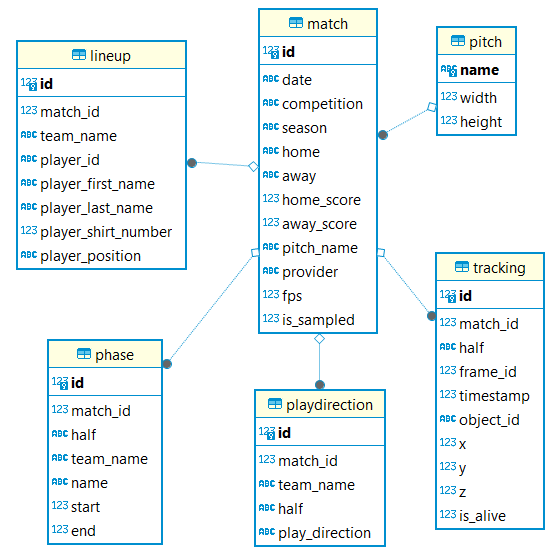

<h3><b>Data Exploration</b></h3>

Let's load back the data we parsed:

In [33]:
metadata_df = pd.read_csv(data_dir / f"{match_id}_metadata.csv")
play_direction_df = pd.read_csv(data_dir / f"{match_id}_play_direction.csv")
phase_df = pd.read_csv(data_dir / f"{match_id}_phase.csv")
lineup_df = pd.read_csv(data_dir / f"{match_id}_lineup.csv")
tracking_df = pd.read_csv(data_dir / f"{match_id}_tracking.csv")
visible_area_df = pd.read_csv(data_dir / f"{match_id}_visible_area.csv")
physical_df = pd.read_csv(data_dir / f"{match_id}_physical.csv")
passes_df = pd.read_csv(data_dir / f"{match_id}_passes.csv")
on_ball_pressures_df = pd.read_csv(data_dir / f"{match_id}_on_ball_pressures.csv")
off_ball_runs_df = pd.read_csv(data_dir / f"{match_id}_off_ball_runs.csv")
max_ball_z = int(tracking_df.z.max()) # what is the maximum ball height in meters that we see in our dataset.

We first display the tracking data results:

In [34]:
print("metadata_df's top five rows:")
display(metadata_df)
print("\nplay_direction_df:")
display(play_direction_df)
print("\nphase_df's top five rows:")
display(phase_df.head())
print("\nlineup_df's top five rows:")
display(lineup_df.head())
print("\ntracking_df's top five rows:")
display(tracking_df.head())
print("\nvisible_area_df's top five rows:")
display(visible_area_df.head())
print(f"maximum ball height is {max_ball_z} meters")

metadata_df's top five rows:


,match_id,match_date,competition,season,home_team,away_team,home_score,away_score,home_team_jersey_color,away_team_jersey_color,home_team_number_color,away_team_number_color,home_team_coach,away_team_coach,pitch_name,pitch_length,pitch_width,provider,fps
0,1381516,11/21/2023 19:45,Friendly International,2023,Austria,Germany,2,0,#e8000a,#ffffff,#ffffff,#000000,Franco Foda,Joachim Low,Ernst-Happel-Stadion,105.0,68.0,SkillCorner,10



play_direction_df:


,match_id,team_name,half,play_direction
0,1381516,Austria,1,BOTTOM_TO_TOP
1,1381516,Germany,1,TOP_TO_BOTTOM
2,1381516,Austria,2,TOP_TO_BOTTOM
3,1381516,Germany,2,BOTTOM_TO_TOP



phase_df's top five rows:


,match_id,half,team_name,name,start,end
0,1381516,1,Germany,IN_POSSESSION,225,311
1,1381516,1,Austria,OUT_POSSESSION,225,311
2,1381516,1,Austria,IN_POSSESSION,458,468
3,1381516,1,Germany,OUT_POSSESSION,458,468
4,1381516,1,Germany,IN_POSSESSION,469,488



lineup_df's top five rows:


,match_id,team_name,player_id,player_first_name,player_last_name,player_shirt_number,player_position,player_birthdate,start_time,end_time,yellow_card,red_card,injured,goal,own_goal
0,1381516,Germany,6184,Leroy,Sané,19,Right Forward,1996-01-11,00:00:00,00:49:40,0,1,False,0,0
1,1381516,Germany,12485,Kai,Havertz,7,Left Wing Back,1999-06-11,00:00:00,01:16:29,0,0,False,0,0
2,1381516,Germany,7077,Marvin,Ducksch,20,Left Winger,1994-03-07,01:16:29,NaN,0,0,False,0,0
3,1381516,Germany,9724,Serge,Gnabry,10,Left Forward,1995-07-14,00:00:00,01:00:44,0,0,False,0,0
4,1381516,Germany,19498,Robert,Andrich,23,Left Midfield,1994-09-22,01:00:44,NaN,0,0,False,0,0



tracking_df's top five rows:


,match_id,half,frame_id,timestamp,object_id,x,y,z,extrapolated
0,1381516,1,208,18800,-1,21.71,-8.16,0.26,True
1,1381516,1,208,18800,16657,-38.07,-0.19,0.00,True
2,1381516,1,208,18800,11350,-11.29,-6.01,0.00,True
3,1381516,1,208,18800,2395,-13.30,4.40,0.00,True
4,1381516,1,208,18800,12755,-8.31,-17.52,0.00,True



visible_area_df's top five rows:


,match_id,frame_id,x_top_left,y_top_left,x_bottom_left,y_bottom_left,x_bottom_right,y_bottom_right,x_top_right,y_top_right
0,1381516,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1381516,209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1381516,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1381516,211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1381516,212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


maximum ball height is 14 meters


If you pay attention to the head coach names in `metadata_df`, you notice that the raw data does not always come 100% correct. Dealing with these situations is also part of your project 😎

Then, game intelligence results:

In [35]:
print("physical_df's top five rows:")
display(physical_df.head())
print("\npasses_df's top five rows:")
display(passes_df.head())
print("\non_ball_pressures_df's top five rows:")
display(on_ball_pressures_df.head())
print("\noff_ball_runs_df's top five rows:")
display(off_ball_runs_df.head())

# Let's change a column header in off_ball_runs_df
off_ball_runs_df.rename(columns={"team_name":"Team"}, inplace=True)

physical_df's top five rows:


,match_id,player_id,quality_check,Distance 1,Distance,Distance 2,Sprinting Distance 1,Sprinting Distance,Sprinting Distance 2,HSR Distance 1,HSR Distance,HSR Distance 2,Running Distance 1,Running Distance,Running Distance 2,Count HSR 1,Count HSR,Count HSR 2,Count Sprint 1,Count Sprint,Count Sprint 2,Count Medium Acceleration 1,Count Medium Acceleration,Count Medium Acceleration 2,Count Medium Deceleration 1,Count Medium Deceleration,Count Medium Deceleration 2,Count High Acceleration 1,Count High Acceleration,Count High Acceleration 2,Count High Deceleration 1,Count High Deceleration,Count High Deceleration 2,Distance TIP 1,Distance TIP,Distance TIP 2,Sprinting Distance TIP 1,Sprinting Distance TIP,Sprinting Distance TIP 2,HSR Distance TIP 1,HSR Distance TIP,HSR Distance TIP 2,Running Distance TIP 1,Running Distance TIP,Running Distance TIP 2,Count HSR TIP 1,Count HSR TIP,Count HSR TIP 2,Count Sprint TIP 1,Count Sprint TIP,Count Sprint TIP 2,Count Medium Acceleration TIP 1,Count Medium Acceleration TIP,Count Medium Acceleration TIP 2,Count Medium Deceleration TIP 1,Count Medium Deceleration TIP,Count Medium Deceleration TIP 2,Count High Acceleration TIP 1,Count High Acceleration TIP,Count High Acceleration TIP 2,Count High Deceleration TIP 1,Count High Deceleration TIP,Count High Deceleration TIP 2,Distance OTIP 1,Distance OTIP,Distance OTIP 2,Sprinting Distance OTIP 1,Sprinting Distance OTIP,Sprinting Distance OTIP 2,HSR Distance OTIP 1,HSR Distance OTIP,HSR Distance OTIP 2,Running Distance OTIP 1,Running Distance OTIP,Running Distance OTIP 2,Count HSR OTIP 1,Count HSR OTIP,Count HSR OTIP 2,Count Sprint OTIP 1,Count Sprint OTIP,Count Sprint OTIP 2,Count Medium Acceleration OTIP 1,Count Medium Acceleration OTIP,Count Medium Acceleration OTIP 2,Count Medium Deceleration OTIP 1,Count Medium Deceleration OTIP,Count Medium Deceleration OTIP 2,Count High Acceleration OTIP 1,Count High Acceleration OTIP,Count High Acceleration OTIP 2,Count High Deceleration OTIP 1,Count High Deceleration OTIP,Count High Deceleration OTIP 2,PSV-99,Minutes TIP 1,Minutes TIP,Minutes TIP 2,Minutes OTIP 1,Minutes OTIP,Minutes OTIP 2,Minutes 1,Minutes,Minutes 2,count_match,count_match_failed,player_name,short_name,player_birthdate,match_name,date
0,1381516,993,True,4909.0,9991,5082.0,106.0,245,139.0,210.0,404,194.0,505.0,1087,582.0,16.0,32,16.0,4.0,10,6.0,36.0,74,38.0,34.0,70,36.0,5.0,8,3.0,7.0,12,5.0,1888.0,3474,1586.0,16.0,28,12.0,79.0,94,15.0,210.0,305,95.0,7.0,9,2.0,2.0,3,1.0,16.0,26,10.0,15.0,27,12.0,0.0,0,0.0,1.0,2,1.0,1615.0,3443.0,1828.0,62.0,187.0,125.0,104.0,275.0,171.0,255.0,616.0,361.0,7.0,20.0,13.0,2.0,7.0,5.0,16.0,33.0,17.0,9.0,20.0,11.0,2.0,3.0,1.0,0.0,1.0,1.0,30.8,15.53,30.71,15.18,12.23,25.91,13.68,47.28,98.83,51.55,1,0,Antonio Rüdiger,A. Rüdiger,1993-03-03,Austria v Germany,2023-11-21
1,1381516,1279,True,NaN,4841,4841.0,NaN,107,107.0,NaN,295,295.0,NaN,717,717.0,NaN,16,16.0,NaN,5,5.0,NaN,46,46.0,NaN,35,35.0,NaN,5,5.0,NaN,11,11.0,NaN,1812,1812.0,NaN,53,53.0,NaN,127,127.0,NaN,317,317.0,NaN,9,9.0,NaN,3,3.0,NaN,16,16.0,NaN,14,14.0,NaN,1,1.0,NaN,3,3.0,NaN,1621.0,1621.0,NaN,45.0,45.0,NaN,153.0,153.0,NaN,319.0,319.0,NaN,7.0,7.0,NaN,2.0,2.0,NaN,17.0,17.0,NaN,10.0,10.0,NaN,1.0,1.0,NaN,2.0,2.0,28.2,0.00,13.78,13.78,0.00,11.37,11.37,0.00,43.95,43.95,1,0,Benjamin Paa Kwesi Henrichs,B. Henrichs,1997-02-23,Austria v Germany,2023-11-21
2,1381516,2395,True,5001.0,9430,4429.0,49.0,109,60.0,208.0,398,190.0,657.0,1216,559.0,15.0,31,16.0,4.0,7,3.0,39.0,79,40.0,37.0,70,33.0,9.0,13,4.0,7.0,15,8.0,1519.0,2897,1378.0,1.0,16,15.0,31.0,85,54.0,222.0,352,130.0,3.0,6,3.0,0.0,1,1.0,11.0,19,8.0,13.0,20,7.0,0.0,0,0.0,1.0,2,1.0,2078.0,3803.0,1725.0,46.0,91.0,45.0,156.0,276.0,120.0,344.0,664.0,320.0,10.0,21.0,11.0,3.0,5.0,2.0,21.0,38.0,17.0,12.0,25.0,13.0,3.0,4.0,1.0,2.0,4.0,2.0,29.4,12.23,23.76,11.53,15.53,29.01,13.48,47.28,91.16,43.88,1,0,David Olatukunbo Alaba,D. Alaba,1992-06-24,Austria v Germany,2023-11-21
3,1381516,4450,True,5481.0,7313,1832.0,42.0,73,31.0,200.0,31


passes_df's top five rows:


,player_id,player_name,short_name,player_birthdate,match_id,match_name,match_date,team_id,team_name,competition_id,competition_name,season_id,season_name,competition_edition_id,position,group,result,venue,third,channel,minutes_played_per_match,adjusted_min_tip_per_match,quality_check,count_opportunities_to_pass_to_runs_in_sample,count_opportunities_to_pass_to_runs_per_match,count_pass_attempts_to_runs_per_match,pass_opportunities_to_runs_threat_per_match,runs_to_which_pass_attempted_threat_per_match,pass_completion_ratio_to_runs,count_runs_by_teammate_per_match,runs_to_which_pass_completed_threat_per_match,count_completed_pass_to_runs_per_match,count_completed_pass_to_runs_leading_to_shot_per_match,count_completed_pass_to_runs_leading_to_goal_per_match,count_pass_opportunities_to_dangerous_runs_per_match,count_pass_attempts_to_dangerous_runs_per_match,count_completed_pass_to_dangerous_runs_per_match
0,993,Antonio Rüdiger,A. Rüdiger,1993-03-03,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,LCB,Central Defender,lose,away,all,all,98.83,24.46,True,19,19.0,10.0,0.08,0.05,90.00,22.0,0.04,9.0,1.0,0.0,0.0,0.0,0.0
1,12484,Jonathan Tah,J. Tah,1996-02-11,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,RCB,Central Defender,lose,away,all,all,98.83,24.46,True,22,22.0,13.0,0.38,0.27,61.54,29.0,0.07,8.0,0.0,0.0,4.0,2.0,1.0
2,7207,Mats Hummels,M. Hummels,1988-12-16,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,CB,Central Defender,lose,away,all,all,98.83,24.46,True,10,10.0,5.0,0.03,0.02,100.00,10.0,0.02,5.0,0.0,0.0,0.0,0.0,0.0
3,2395,David Olatukunbo Alaba,D. Alaba,1992-06-24,1381516,Austria v Germany,2023-11-21,387,Austria,20,Friendly International,22,2023,520,LCB,Central Defender,win,home,all,all,91.17,20.29,True,11,11.0,3.0,0.06,0.05,66.67,14.0,0.01,2.0,0.0,0.0,1.0,1.0,0.0
4,12052,Kevin Danso,K. Danso,1998-09-19,1381516,Austria v Germany,2023-11-21,387,Austria,20,Friendly International,22,2023,520,LCB,Central Defender,win,home,all,all,7.67,2.01,True,0,0.0,0.0,0.00,0.00,NaN,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0



on_ball_pressures_df's top five rows:


,player_id,player_name,short_name,player_birthdate,match_id,match_name,match_date,team_id,team_name,competition_id,competition_name,season_id,season_name,competition_edition_id,position,group,result,venue,third,channel,minutes_played_per_match,adjusted_min_tip_per_match,quality_check,count_pressures_received_in_sample,count_pressures_received_per_match,count_forced_losses_under_pressure_per_match,count_ball_retentions_under_pressure_per_match,ball_retention_ratio_under_pressure,pass_completion_ratio_under_pressure,count_pass_attempts_under_pressure_per_match,count_completed_passes_under_pressure_per_match,count_dangerous_pass_attempts_under_pressure_per_match,count_completed_dangerous_passes_under_pressure_per_match,dangerous_pass_completion_ratio_under_pressure,count_difficult_pass_attempts_under_pressure_per_match,count_completed_difficult_passes_under_pressure_per_match,difficult_pass_completion_ratio_under_pressure
0,993,Antonio Rüdiger,A. Rüdiger,1993-03-03,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,LCB,Central Defender,lose,away,all,all,98.83,24.46,True,37,37.0,6.0,31.0,83.78,87.88,33.0,29.0,0.0,0.0,NaN,3.0,3.0,100.00
1,12484,Jonathan Tah,J. Tah,1996-02-11,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,RCB,Central Defender,lose,away,all,all,98.83,24.46,True,37,37.0,9.0,28.0,75.68,72.73,33.0,24.0,3.0,2.0,66.67,7.0,4.0,57.14
2,7207,Mats Hummels,M. Hummels,1988-12-16,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,CB,Central Defender,lose,away,all,all,98.83,24.46,True,46,46.0,9.0,37.0,80.43,84.62,39.0,33.0,0.0,0.0,NaN,5.0,2.0,40.00
3,2395,David Olatukunbo Alaba,D. Alaba,1992-06-24,1381516,Austria v Germany,2023-11-21,387,Austria,20,Friendly International,22,2023,520,LCB,Central Defender,win,home,all,all,91.17,20.29,True,31,31.0,4.0,27.0,87.10,85.71,28.0,24.0,1.0,0.0,0.00,6.0,3.0,50.00
4,12052,Kevin Danso,K. Danso,1998-09-19,1381516,Austria v Germany,2023-11-21,387,Austria,20,Friendly International,22,2023,520,LCB,Central Defender,win,home,all,all,7.67,2.01,True,2,2.0,0.0,2.0,100.00,100.00,2.0,2.0,0.0,0.0,NaN,0.0,0.0,NaN



off_ball_runs_df's top five rows:


,player_id,player_name,short_name,player_birthdate,match_id,match_name,match_date,team_id,team_name,competition_id,competition_name,season_id,season_name,competition_edition_id,position,group,result,venue,third,channel,minutes_played_per_match,adjusted_min_tip_per_match,quality_check,count_runs_in_sample,count_runs_per_match,count_dangerous_runs_per_match,runs_threat_per_match,count_runs_leading_to_goal_per_match,count_runs_targeted_per_match,count_runs_received_per_match,count_runs_leading_to_shot_per_match,runs_targeted_threat_per_match,runs_received_threat_per_match,count_dangerous_runs_targeted_per_match,count_dangerous_runs_received_per_match
0,993,Antonio Rüdiger,A. Rüdiger,1993-03-03,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,LCB,Central Defender,lose,away,all,all,98.83,24.46,True,4,4.0,0.0,0.01,0.0,3.0,3.0,0.0,0.00,0.00,0.0,0.0
1,12484,Jonathan Tah,J. Tah,1996-02-11,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,RCB,Central Defender,lose,away,all,all,98.83,24.46,True,21,21.0,0.0,0.07,0.0,7.0,7.0,0.0,0.02,0.02,0.0,0.0
2,7207,Mats Hummels,M. Hummels,1988-12-16,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,CB,Central Defender,lose,away,all,all,98.83,24.46,True,7,7.0,0.0,0.02,0.0,2.0,2.0,0.0,0.00,0.00,0.0,0.0
3,2395,David Olatukunbo Alaba,D. Alaba,1992-06-24,1381516,Austria v Germany,2023-11-21,387,Austria,20,Friendly International,22,2023,520,LCB,Central Defender,win,home,all,all,91.17,20.29,True,9,9.0,0.0,0.04,0.0,4.0,4.0,0.0,0.02,0.02,0.0,0.0
4,12052,Kevin Danso,K. Danso,1998-09-19,1381516,Austria v Germany,2023-11-21,387,Austria,20,Friendly International,22,2023,520,LCB,Central Defender,win,home,all,all,7.67,2.01,True,2,2.0,0.0,0.00,0.0,1.0,1.0,0.0,0.00,0.00,0.0,0.0


<h3><b>Animation Creation</b></h3>

Let's visualize our data by first drawing a picture per frame and then concatenating them to create an animation.

To do so, we will make use of the famous [mplsoccer](https://mplsoccer.readthedocs.io) package for drawing a vertical football pitch.

But before doing so, we first need to have one cell containing all the required functions:

In [36]:
def truncate(float_number, decimal_places):
    """This function truncates a float number to the given decimal places"""
    multiplier = 10**decimal_places
    return int(float_number * multiplier) / multiplier

def get_match_time(timestamp, half):
    """Return the running match time (start from the first half kick-off) from the given timestamp and half"""
    half_start = 0
    if half == 2:
        half_start = 45 * 60 * 1000
    seconds = int((timestamp + half_start) / 1000)
    minutes = int(seconds / 60)
    seconds = seconds % 60
    match_time = f"{minutes}:{seconds:02d}"
    return match_time

def animate(img_dir, f_start, f_end, animate_fps):
    """Animate the match from the given start frame to the given end frame by concatinating the already drawn images of each team per frame."""
    image_ids = [i for i in range(f_start, f_end)]

    images = []
    for i in image_ids:
        file = img_dir / f"{i}.png"
        if file.is_file():
            images.append(file)
    with iio.get_writer(
        match_dir / f"{img_dir.parent.stem}_{f_start}_to_{f_end}_animation.mp4", format="FFMPEG", mode="I", fps=animate_fps
    ) as writer:
        # Loop over the images and write them to the video after concatination of the left and right images
        for index in tqdm(range(len(images))):
            im = iio.imread(images[index])
            writer.append_data(im)
            
def plot(store_path, frame_id, timestamp, half, metadata_df, ball_df, home_df, away_df, home_lineup_df, away_lineup_df, home, away, visible_area):
    match_time = get_match_time(timestamp, half)

    pitch_size = (metadata_df["pitch_width"].iloc[0], metadata_df["pitch_length"].iloc[0])
    match_date = metadata_df["match_date"].iloc[0].split(" ")[0]
    pitch = VerticalPitch(
        pitch_type="secondspectrum",
        pitch_width=pitch_size[0],
        pitch_length=pitch_size[1],
        line_color="#E2E2E2",
    )

    # we make use of team shirt and number colors provided in the metadata file
    team_shirt_colors = [metadata_df["home_team_jersey_color"].iloc[0], metadata_df["away_team_jersey_color"].iloc[0]]
    team_number_colors = [metadata_df["home_team_number_color"].iloc[0], metadata_df["away_team_number_color"].iloc[0]]
    lineups = [home_lineup_df, away_lineup_df]
    
    fig, ax = pitch.draw(figsize=(pitch_size[0]/10, pitch_size[1]/10))

    # The TV broadcast camera view of the pitch (if available) is depicted as a light green polygon. 
    corner_coords = []
    for corner in ["top_left","bottom_left","bottom_right","top_right","top_left"]:
        corner_coords.append((visible_area[f"x_{corner}"],visible_area[f"y_{corner}"]))
    
    if corner_coords!=[]:
        pitch.polygon([corner_coords], color="#4c8527", alpha=0.05, ax=ax)

    # Per team, draw the players
    for index, team in enumerate([home_df, away_df]):
        shirt_color = team_shirt_colors[index]
        number_color = team_number_colors[index]
        lineup = lineups[index]
        id2shirt= dict(zip(lineup['player_id'], lineup['player_shirt_number']))
        for _, player in team.iterrows():
            pnum = id2shirt[player["object_id"]]
            pitch.plot(
                truncate(player['x'], 1),
                truncate(player['y'], 1),
                ax=ax,
                linewidth=0,
                marker="o",
                markersize=20,
                markeredgecolor = "black",
                color=shirt_color)
            
            pitch.annotate(
                pnum,
                xy=(truncate(player['x'], 1), truncate(player['y'], 1)),
                c=number_color,
                va="center",
                ha="center",
                size=11,
                weight="bold",
                ax=ax)

    # Plot the ball
    relative_ball_height = 1 - ((max_ball_z - truncate(ball_df["z"].iloc[0], 1)) / max_ball_z)
    pitch.plot(truncate(ball_df["x"].iloc[0], 1),
               truncate(ball_df["y"].iloc[0], 1),
               ax=ax,
               linewidth=0,
               marker="o",
               markersize=10,
               markeredgecolor="black",
               markerfacecolor=str(max(relative_ball_height, 0))
              )
    
    ax.set_title(f"{home} vs. {away} on {match_date}, Half: {half}, Time: {match_time}")

    # Save the figure
    fig.savefig(store_path / f"{frame_id}.png", dpi=160)
    plt.close(fig)

Now, we extract the basic match info from `metadata_df` and create the `results` folder! 

In [37]:
home = metadata_df["home_team"].iloc[0]
away = metadata_df["away_team"].iloc[0]
date = metadata_df["match_date"].iloc[0]
date = "-".join(date.split(' ')[0].split("/"))
match_name = f"{home} - {away} - {date}"
results_dir = Path("results")
match_dir = results_dir / match_name
img_dir = match_dir / "img"

# Remove the match directory if it exists
if match_dir.exists():
    shutil.rmtree(match_dir, ignore_errors=True)
    
# Create the match directory to store the results
match_dir.mkdir(parents=True)
img_dir.mkdir()

animate_fps = int(metadata_df["fps"].iloc[0])
ball_df = tracking_df[tracking_df.object_id==int(SkillCorner.ball_id)]
frames_df = tracking_df[tracking_df.object_id!=int(SkillCorner.ball_id)]

Below, set the desired start and end frames to create the images for the animation:

In [38]:
f_start = ball_df.frame_id.min() # start frame_id
f_end = f_start + 1000 # end frame_id

print(f"Selected frame ids to animate is from {f_start} to {f_end}.")

selected_ball_df = ball_df[(ball_df.frame_id>=f_start)&(ball_df.frame_id<=f_end)]

Selected frame ids to animate is from 208 to 1208.


Iterate over time to draw an image per frame in the selected time window. After running the following cell, you can check the `results` folder where in the match's directory, the images are stored under `img` subfolder.

In [39]:
home_lineup_df = lineup_df[lineup_df.team_name == home]
home_frames_df = frames_df[frames_df.object_id.isin(home_lineup_df.player_id.unique())]

away_lineup_df = lineup_df[lineup_df.team_name == away]
away_frames_df = frames_df[frames_df.object_id.isin(away_lineup_df.player_id.unique())]

print(f"{home} vs. {away} on {str(date).split(' ')[0]} ...")
for frame_id in tqdm(selected_ball_df.frame_id.unique()):
    home_df = home_frames_df[home_frames_df.frame_id==frame_id]
    away_df = away_frames_df[away_frames_df.frame_id==frame_id]
    ball = ball_df[ball_df.frame_id==frame_id]
    timestamp = list(ball.timestamp)[0]
    half = list(ball.half)[0]
    visible_area = visible_area_df[visible_area_df.frame_id==frame_id].drop(columns=["match_id","frame_id"]).iloc[0]
    plot(img_dir, frame_id, timestamp, half, metadata_df, ball, home_df, away_df, home_lineup_df, away_lineup_df, home, away, visible_area)

Austria vs. Germany on 11-21-2023 ...


100%|████████████████████████████████████████████████████████████████████████████████| 850/850 [04:48<00:00,  2.95it/s]


Finally, we concatenate the images to create the animation. The `mp4` file will be available next to the `img` subfolder.

In [40]:
animate(img_dir, f_start, f_end, animate_fps)

100%|████████████████████████████████████████████████████████████████████████████████| 850/850 [00:28<00:00, 29.45it/s]


Before uploading `mp4` files into wiki, make sure your file size stays small!

<h3><b>Game Intelligence</b></h3>

The game intelligence data will be covered by SkillCorner in the course. 

For now, let's create a simple scatter plot from their `off_ball_runs` data.

In [41]:
off_ball_runs_df.head()

,player_id,player_name,short_name,player_birthdate,match_id,match_name,match_date,team_id,Team,competition_id,competition_name,season_id,season_name,competition_edition_id,position,group,result,venue,third,channel,minutes_played_per_match,adjusted_min_tip_per_match,quality_check,count_runs_in_sample,count_runs_per_match,count_dangerous_runs_per_match,runs_threat_per_match,count_runs_leading_to_goal_per_match,count_runs_targeted_per_match,count_runs_received_per_match,count_runs_leading_to_shot_per_match,runs_targeted_threat_per_match,runs_received_threat_per_match,count_dangerous_runs_targeted_per_match,count_dangerous_runs_received_per_match
0,993,Antonio Rüdiger,A. Rüdiger,1993-03-03,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,LCB,Central Defender,lose,away,all,all,98.83,24.46,True,4,4.0,0.0,0.01,0.0,3.0,3.0,0.0,0.00,0.00,0.0,0.0
1,12484,Jonathan Tah,J. Tah,1996-02-11,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,RCB,Central Defender,lose,away,all,all,98.83,24.46,True,21,21.0,0.0,0.07,0.0,7.0,7.0,0.0,0.02,0.02,0.0,0.0
2,7207,Mats Hummels,M. Hummels,1988-12-16,1381516,Austria v Germany,2023-11-21,0,Germany,20,Friendly International,22,2023,520,CB,Central Defender,lose,away,all,all,98.83,24.46,True,7,7.0,0.0,0.02,0.0,2.0,2.0,0.0,0.00,0.00,0.0,0.0
3,2395,David Olatukunbo Alaba,D. Alaba,1992-06-24,1381516,Austria v Germany,2023-11-21,387,Austria,20,Friendly International,22,2023,520,LCB,Central Defender,win,home,all,all,91.17,20.29,True,9,9.0,0.0,0.04,0.0,4.0,4.0,0.0,0.02,0.02,0.0,0.0
4,12052,Kevin Danso,K. Danso,1998-09-19,1381516,Austria v Germany,2023-11-21,387,Austria,20,Friendly International,22,2023,520,LCB,Central Defender,win,home,all,all,7.67,2.01,True,2,2.0,0.0,0.00,0.0,1.0,1.0,0.0,0.00,0.00,0.0,0.0


To understand the meaning of each column, check SkillCorner's online [documentation](https://skillcorner.crunch.help/en).

For instance, we want to plot off-ball runs vs. dangerous runs below. But let's first see what <it>dangerous</it> means by searching for that term on the online documentation.

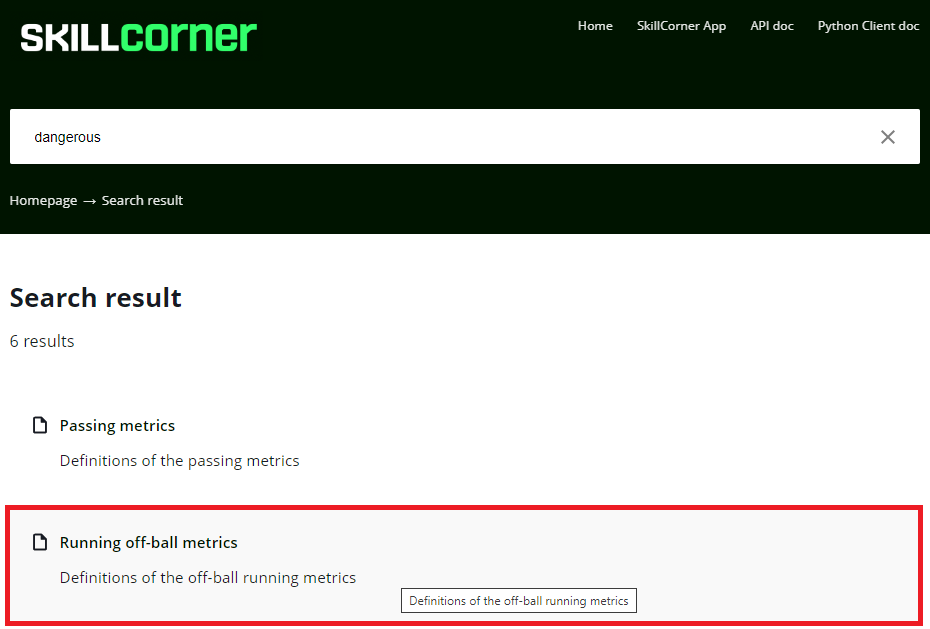

and if you click on that article, you will see their definition of runs and dangerous runs (off-ball):

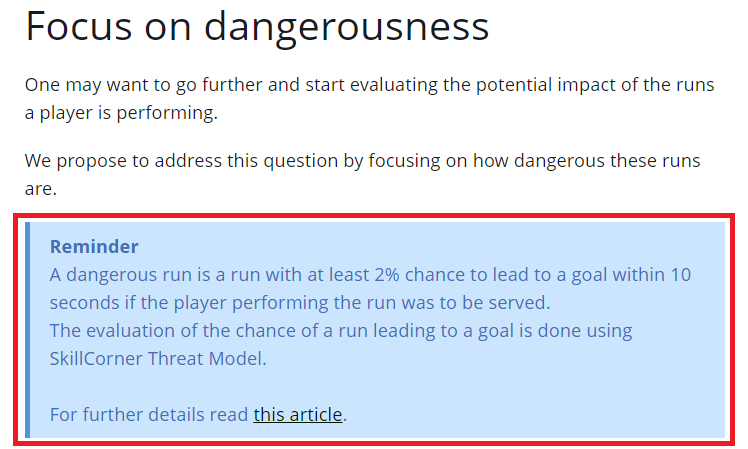

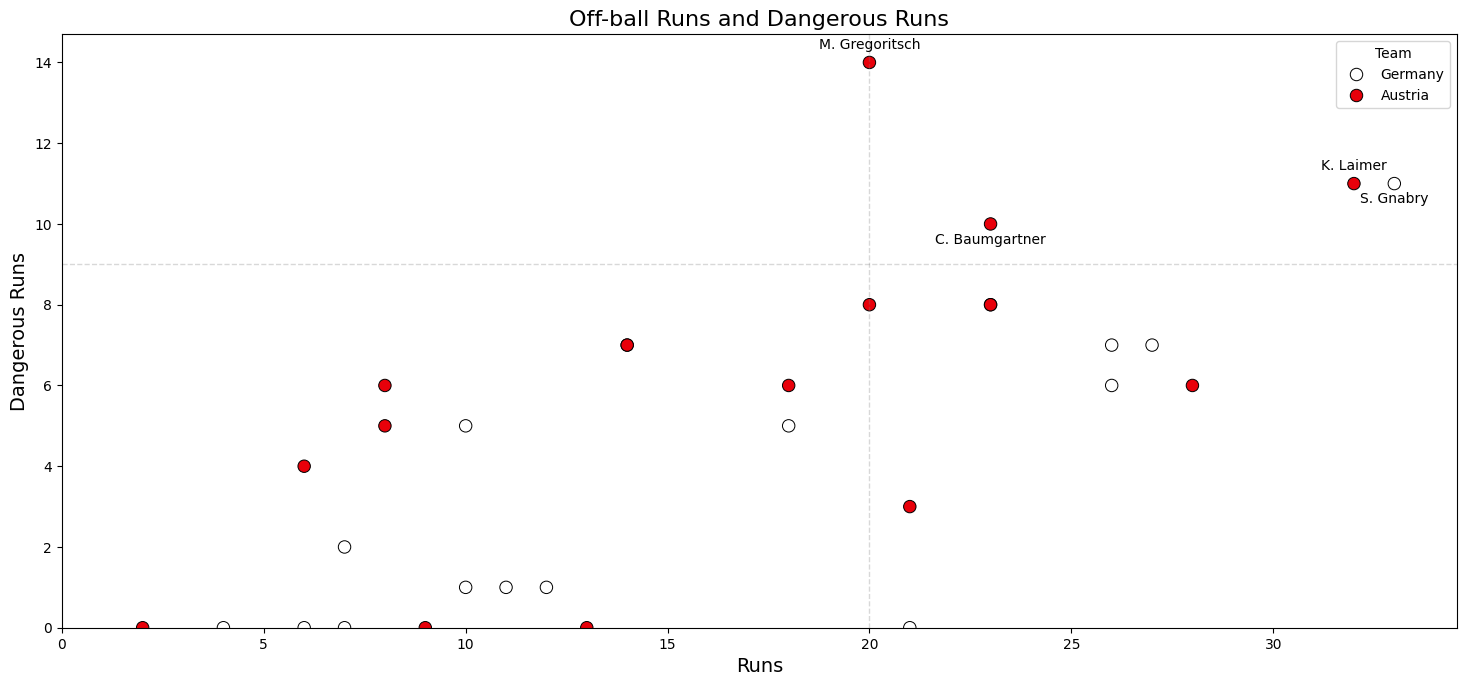

In [42]:
import seaborn as sns
import pandas as pd

# Scatter plot using Seaborn
plt.figure(figsize=(18, 18))

custom_palette = {metadata_df["home_team"].iloc[0]: metadata_df["home_team_jersey_color"].iloc[0], metadata_df["away_team"].iloc[0]:metadata_df["away_team_jersey_color"].iloc[0]}
sns.scatterplot(data=off_ball_runs_df, x='count_runs_per_match', y='count_dangerous_runs_per_match', hue="Team", palette=custom_palette, s=80, edgecolor='black')

# Annotating specific players
count_runs_per_match_threshold = 20
count_dangerous_runs_per_match_threshold = 9
players_to_annotate = off_ball_runs_df[(off_ball_runs_df.count_runs_per_match>=count_runs_per_match_threshold)&(off_ball_runs_df.count_dangerous_runs_per_match>=count_dangerous_runs_per_match_threshold)]["short_name"].unique()

sign = 1
for player in players_to_annotate:
    sign*=-1
    x = off_ball_runs_df[off_ball_runs_df['short_name'] == player]['count_runs_per_match'].values[0]
    y = off_ball_runs_df[off_ball_runs_df['short_name'] == player]['count_dangerous_runs_per_match'].values[0]
    xytext = (0,10) if sign > 0 else (0,-14)
    plt.annotate(player, (x, y), textcoords="offset points", xytext=xytext, ha='center', fontsize=10)

# Adding vertical and horizontal lines
plt.axvline(x=count_runs_per_match_threshold, color='grey', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=count_dangerous_runs_per_match_threshold, color='grey', linestyle='--', linewidth=1, alpha=0.3)

# Adding titles and labels
plt.title('Off-ball Runs and Dangerous Runs', fontsize=16)
plt.xlabel('Runs', fontsize=14)
plt.ylabel('Dangerous Runs', fontsize=14)

plt.gca().set_aspect('equal')

# Setting x-axis and y-axis limits to start from 0
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

# Display plot
plt.grid(False)
plt.show()

As you can see, [Gregoritsch](https://www.transfermarkt.ch/michael-gregoritsch/profil/spieler/120205) made 20 runs in that match and 14 of them were categorized as <b><span style="color:red">Dangerous</span></b> by SkillCorner!

For inspiration, consider reviewing a sample [report](https://26560301.fs1.hubspotusercontent-eu1.net/hubfs/26560301/Game%20Intelligence_Off-Ball%20Runs.pdf) generated from game intelligence data.

<h3><b>Final Remarks</b></h3>

If you are new into Python and its data processing libraries, you can check the following **free** sources:
- [Football-analytics Python Tutorial List](https://github.com/eddwebster/football_analytics#-python) maintined by Edd Webster.
- [Learn Python - Full Course for Beginners](https://www.youtube.com/watch?v=rfscVS0vtbw) by freeCodeCamp.
- [In-depth pandas tutorial](https://towardsdatascience.com/in-depth-pandas-tutorial-5d896483ba8a) by TowardsDataScience.

You can also check the [list of Football Analytics repositories and libraries](https://github.com/eddwebster/football_analytics#-classical_building-libaries) maintained by Edd Webster.

We obviously expect that this notebook remains confidential for the purpose of this course 😊

*For any questions about this notebook, contact [hsotudeh@ethz.ch](mailto:hsotudeh@ethz.ch).*